<a href="https://colab.research.google.com/github/Ajmaljalal/Deep-Learning/blob/main/openai_whisper_small_pashto_STT_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install evaluate
!pip install jiwer
!pip install torchcodec

In [4]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

import evaluate
wer = evaluate.load('wer')


from scipy.signal import resample

def down_sample_audio(audio_original, original_sample_rate):
    """
    Downsamples an audio array to a target sample rate of 16000 Hz.

    Args:
        audio_original (np.ndarray): The original audio array.
        original_sample_rate (int): The original sample rate of the audio.

    Returns:
        np.ndarray: The downsampled audio array at 16000 Hz.
    """
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

In [5]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small",language='pashto',task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='pashto',task='transcribe')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [6]:
pashto_text = 'زه ښوونځي ته ځم او سبا بېرته راځم.'

tokenized_text = tokenizer(pashto_text)

tokenizer.decode(tokenized_text.input_ids)

'<|startoftranscript|><|ps|><|transcribe|><|notimestamps|>زه ښوونځي ته ځم او سبا بېرته راځم.<|endoftext|>'

In [7]:
from huggingface_hub import notebook_login
notebook_login()

In [8]:
from datasets import load_dataset,concatenate_datasets
import os

cv_17 = load_dataset("ihanif/common_voice_ps_20_0", split=["train","other","test"])

save_dir_data = '/content/drive/MyDrive/AI ML Learning/pashto/datasets'

os.makedirs(os.path.join(save_dir_data, 'cv_17_train_split'), exist_ok=True)
os.makedirs(os.path.join(save_dir_data, 'cv_17_other_split'), exist_ok=True)
os.makedirs(os.path.join(save_dir_data, 'cv_17_test_split'), exist_ok=True)

cv_17[0].save_to_disk(os.path.join(save_dir_data, 'cv_17_train_split'))
cv_17[1].save_to_disk(os.path.join(save_dir_data, 'cv_17_other_split'))
cv_17[2].save_to_disk(os.path.join(save_dir_data, 'cv_17_test_split'))

print(f"CV_17 Train split data saved to: {os.path.join(save_dir_data, 'cv_17_train_split')}")
print(f"CV_17 Other split data saved to: {os.path.join(save_dir_data, 'cv_17_other_split')}")
print(f"CV_17 Test split data saved to: {os.path.join(save_dir_data, 'cv_17_test_split')}")

Saving the dataset (0/1 shards):   0%|          | 0/3368 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/33077 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2801 [00:00<?, ? examples/s]

CV_17 Train split data saved to: /content/drive/MyDrive/AI ML Learning/pashto/datasets/cv_17_train_split
CV_17 Other split data saved to: /content/drive/MyDrive/AI ML Learning/pashto/datasets/cv_17_other_split
CV_17 Test split data saved to: /content/drive/MyDrive/AI ML Learning/pashto/datasets/cv_17_test_split


In [9]:
train_data = cv_17[0]
test_data = cv_17[2]

print(f"Train data has {len(train_data)} examples.")
print(f"Test data has {len(test_data)} examples.")

Train data has 3368 examples.
Test data has 2801 examples.


In [10]:
train_data[0]

{'client_id': 'fbe6ba987af581f593fd776c3e745e8fbdc3254d4d2c453f90849596f0af1ca34143655cba559984773690a18cc7810d6849dcf8ceee79ceea1946f402e6c17a',
 'path': 'common_voice_ps_41355148.mp3',
 'sentence_id': 'd6be46f9faa4c8aafb93fed3455f91ab66ad1321733170ba39f5a663af7989de',
 'sentence': 'ځان پېښو ته که په ژوره توګه وکتل شي',
 'sentence_domain': 'general',
 'up_votes': 2,
 'down_votes': 0,
 'age': 'fourties',
 'gender': 'unknown',
 'accent': 'unknown',
 'variant': 0.0,
 'locale': 'ps',
 'segment': '',
 'duration': 6300.0,
 'audio': <datasets.features._torchcodec.AudioDecoder at 0x7a8a80c4a540>}

In [11]:
text = train_data[0]['sentence']
tok_sentence = tokenizer(text)
tok_sentence

{'input_ids': [50258, 50340, 50359, 50363, 150, 223, 7649, 21453, 151, 238, 150, 248, 2407, 6055, 3224, 7565, 3224, 21453, 3224, 220, 150, 246, 13063, 3224, 33427, 150, 104, 3224, 4032, 6007, 2655, 1211, 44049, 50257], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
from IPython.display import clear_output
import time

for idx in range(len(tok_sentence.input_ids)):
    print(tokenizer.decode(tok_sentence.input_ids[:idx]))
    clear_output(wait=True)
    time.sleep(.1)

<|startoftranscript|><|ps|><|transcribe|><|notimestamps|>ځان پېښو ته که په ژوره توګه وکتل شي


Map:   0%|          | 0/3368 [00:00<?, ? examples/s]

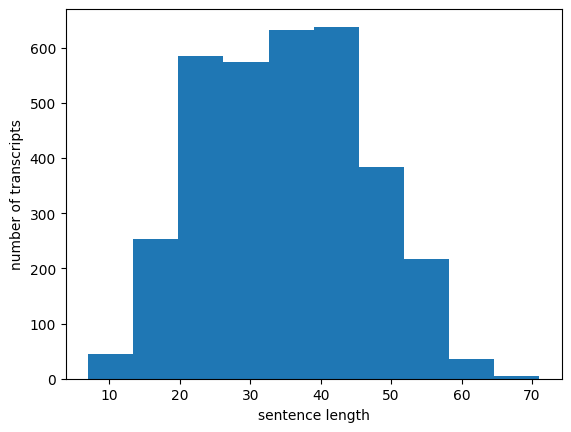

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True)

tokenized_dataset = train_data.map(tokenize_function, batched=True)

list_of_transcription_lengths = [len(x) for x in tokenized_dataset['input_ids']]

plt.hist(list_of_transcription_lengths)
plt.xlabel("sentence length")
plt.ylabel("number of transcripts")
plt.show()

In [14]:
import torch

for idx in range(5):

    target = train_data[idx]['sentence']
    audio_original = train_data[idx]['audio']['array']
    original_sample_rate = train_data[idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='pashto', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


-------0------
true : ځان پېښو ته که په ژوره توګه وکتل شي 
pred :  زان پی خو تا ک پجاورتو گا و قتلشی.

 
-------1------
true : زیتون باغونه د ننګرهار په کانال کې دي. 
pred :  زیطون بغون دن اگراحار پا کنال کیدی.

 
-------2------
true : ګیدړه مکاره ده. 
pred :  Gidda Makarada

 
-------3------
true : د خاطراتو لیکل د ژوند په وروستیو کې ډېر معمول دي. 
pred :  دخاترات و لکل در جون پورستی و کدیر معمول ده

 
-------4------
true : پر خپلې کورنۍ مې زېری وکړ. 
pred :  پرخبالی کورانای می زیر وکل

 


In [15]:
class whisper_training_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len):#daatset is huggingface dataset object
        self.dataset = dataset
        self.max_len = max_len
        self.bos_token = model.config.decoder_start_token_id

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        audio_data = down_sample_audio(item['audio']["array"], item['audio']["sampling_rate"])
        input_features = feature_extractor(audio_data, sampling_rate=16000,return_tensors='pt').input_features[0]

        # Process the transcription
        transcription = item["sentence"]

        # Create labels
        labels = tokenizer(transcription, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = labels["input_ids"].masked_fill(labels['attention_mask'].ne(1), -100)
        labels = labels[0][1:]


        return {
            "input_features": input_features,
            "labels": labels
        }

In [16]:
dataset = whisper_training_dataset(dataset=train_data, max_len=300)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,  # Adjust batch size as needed
    shuffle=True,  # Shuffle data during training
)

In [17]:
def evaluation(model):

    device='cuda'

    test_dataset = whisper_training_dataset(dataset=test_data, max_len=300)

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=2,  # Adjust batch size as needed
        shuffle=True,  # Shuffle data during training
    )

    model.eval()

    predictions=[]
    references=[]

    for batch in tqdm(test_dataloader,total=len(test_dataloader)):

        model.train()  # Set model to training mode

        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

        with torch.no_grad():
            generated_tokens = model.generate(input_features=input_features,language='bengali', task='transcribe')

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

    WER = wer.compute(predictions=predictions, references=references) * 100

    return WER

In [16]:
# WER before the training
# torch.cuda.empty_cache()
# evaluation(model)

100%|██████████| 351/351 [1:20:23<00:00, 13.74s/it]


249.43946188340806

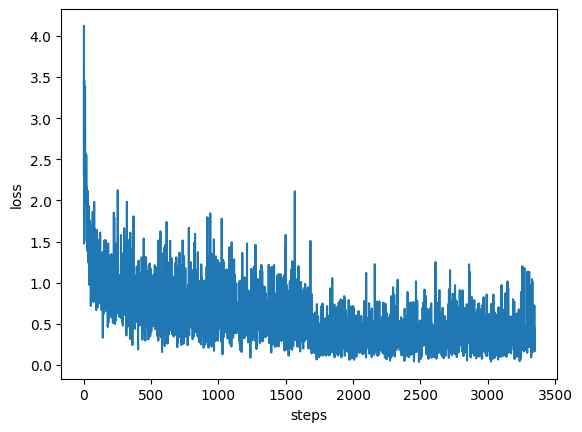

100%|██████████| 1401/1401 [22:00<00:00,  1.06it/s]


In [18]:
from IPython.display import clear_output
torch.cuda.empty_cache()

model.train()

device='cuda'

optimizer=torch.optim.AdamW(model.parameters(), lr=1e-5)
# optimizer=torch.optim.AdamW(requires_grad_params, lr=5e-4) # Only for LoRA Training

max_epochs=2


running_wer=[]
running_loss=[]



for epoch in range(max_epochs):

    for batch in tqdm(train_dataloader,total=len(train_dataloader),leave=False):

        model.train()  # Set model to training mode

        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

        # Forward pass
        outputs = model(input_features, labels=labels)  # Assuming your model takes these inputs
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # Reset gradients

        running_loss.append(loss.item())

        if len(running_loss) % 50 ==0:  # Print loss every 50 batches
            plt.plot(running_loss)
            plt.xlabel('steps')
            plt.ylabel('loss')
            clear_output(wait=True)  # Clear the output to keep the plot clean
            plt.show()

        if len(running_loss) % 100 == 0:  # Save model every 100 steps
            # torch.save(model.state_dict(), f'finetuned_on_odia_steps_{len(running_loss)}.pth')
            model.save_pretrained('lora_model')

    torch.cuda.empty_cache()
    running_wer.append(evaluation(model))

In [21]:
# Define the path to the saved model directory
saved_model_directory = 'lora_model' # Model saved to 'lora_model' directory in current workspace

# Load the entire model from the saved directory
# This re-initializes the 'model' variable with the fine-tuned weights and configuration
model = WhisperForConditionalGeneration.from_pretrained(saved_model_directory).to('cuda')

model.eval()

torch.cuda.empty_cache()
evaluation(model)

  0%|          | 0/1401 [00:00<?, ?it/s]`generation_config` default values have been modified to match model-specific defaults: {'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. If this is not desired, please set these values explicitly.
A custom logits processor of type <class 'transformers.generation.logits_process.SuppressTokensLogitsProcessor'> has been passed to `.generate()`, but it was also created in `.generate()`, given its parameterization. The custom <class 'transformers.generation.

57.129214416209926

In [22]:
model.eval()


for idx in range(5):

    target = test_data[idx]['sentence']
    audio_original = test_data[idx]['audio']['array']
    original_sample_rate = test_data[idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='pashto', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

-------0------
true : د پښتني جګړې لاره د پښتنو د پوځي تکتیکونو مطالعه ده. 
pred : د پښتنې جګۍ لاره د پښتنو د فوځي تکنیکنو مطالعه ده.

 
-------1------
true : د قوشتپې کانال کارونه ډېر ښه پرمخ روان دي. 
pred : د پوښتپې کانال کارونه ډېر خپر وښه غاندې.

 
-------2------
true : اختر مو مبارک سه! 
pred : اخدر مو مبارک شه

 
-------3------
true : يو کس يا يو شې سره ځان عادت کول پريږدٸ. 
pred : يو کاس يې یو ښي سره زون ادد کول پرېږدئ.

 
-------4------
true : که راحت غواړې زحمت درلره بويه. 
pred : دردت ګالې دردت مرکز دردرې وي

 
